# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA


### Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set()


import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [2]:
data_2019 = pd.read_csv('C:/Users/Riggio/Desktop/Tel/Data Science/proyecto 3/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('C:/Users/Riggio/Desktop/Tel/Data Science/proyecto 3/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('C:/Users/Riggio/Desktop/Tel/Data Science/proyecto 3/flujo-vehicular-2017.csv', sep =',')

In [3]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

In [4]:
# Verificamos la información general del dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3560706 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   periodo         int64 
 1   fecha           object
 2   hora_inicio     int64 
 3   hora_fin        int64 
 4   dia             object
 5   estacion        object
 6   sentido         object
 7   tipo_vehiculo   object
 8   forma_pago      object
 9   cantidad_pasos  int64 
dtypes: int64(4), object(6)
memory usage: 298.8+ MB


In [5]:
# Corroboramos si existen valores nulos para alguna categoria
dataset.isnull().sum()

periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64

In [6]:
##### - No existen valores nulos para ningunas categoría en ninguno de los 3 años en estudio

In [7]:
# Dado que a partir de 2019 la estación Dellepiane no distingue entre centro y Liniers la unificaremos
dataset.estacion.replace({'Dellepiane Centro': 'Dellepiane', 'Dellepiane Liniers': 'Dellepiane','Alberti': 'Alberdi'}, inplace=True)
dataset.estacion.unique()

array(['Alberdi', 'Avellaneda', 'Dellepiane', 'Illia', 'Retiro',
       'Salguero', 'Sarmiento', 'PDB'], dtype=object)

In [8]:
# Vemos que la tarjeta de discapacidad tiene 2 nombre diferentes, la unificaremos a como esta en 2019
dataset.forma_pago.replace({'TARJETA DISCAPACIDAD': 'T. DISCAPACIDAD'}, inplace=True)

In [9]:
# Evaluamos ademas la cantidad de registros en cada tipo de pago
dataset.forma_pago.value_counts()

TELEPASE           1027861
EFECTIVO           1020176
EXENTO              464708
INFRACCION          405034
NO COBRADO          380450
T. DISCAPACIDAD     262455
MONEDERO                14
Otros                    8
Name: forma_pago, dtype: int64

In [10]:
# Vemos que los tipo de pago MONEDERO y Otros tienen muy pocos registros, 
# por lo cual los borraremos pues son poco significativos
indx_drop=dataset[(dataset.forma_pago=='MONEDERO') | (dataset.forma_pago=='Otros')].index
dataset.drop(indx_drop, inplace=True)

In [11]:
# Reemplazaremos en la hora final 0 por 24 para que no se presente error en la conversión que haremos a continuación
# (De lo contrario al hacer la conversión de hora se presentará 2017-01-01 00:00:00 en lugar de 2017-01-02 00:00:00 )
dataset.hora_fin.replace({0:24}, inplace=True)
dataset

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberdi,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberdi,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberdi,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberdi,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16
...,...,...,...,...,...,...,...,...,...,...
1372640,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2017,2017-12-31,23,24,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,1


In [12]:
# Hacemos la conversión de la columna fecha a tipo datetime
dataset.fecha = pd.to_datetime(dataset.fecha)

In [13]:
# Obtenemos el mes a partir de la columna fecha y lo incluimos en nuestro dataset
dataset['mes'] = dataset['fecha'].dt.month
# Obtenemos el numero del dia a partir de la columna fecha y lo incluimos en nuestro dataset
dataset['dia_num'] = dataset['fecha'].dt.weekday

In [14]:
dataset['dia_sem'] = dataset.fecha.dt.weekday
dataset['fin_sem'] = dataset.fecha.dt.weekday

In [15]:
dataset['dia_sem'] = dataset['dia_sem'].apply(lambda x: 1 if x <= 4 else 0)
dataset['fin_sem'] = dataset['fin_sem'].apply(lambda x: 1 if x > 4 else 0)

In [16]:
# Generamos una nueva columna de fecha compacta a fartir de la columna fecha y hora
dataset['fecha_comp'] = dataset.fecha + pd.to_timedelta(dataset.hora_fin, unit = 'h')

In [17]:
# Reorganizamos para tener el dataset en una estructura ordenada
dataset=dataset[['fecha_comp', 'fecha', 'periodo','mes', 'hora_inicio', 'hora_fin','dia', 'dia_num','dia_sem','fin_sem',
         'estacion','sentido', 'tipo_vehiculo', 'forma_pago','cantidad_pasos']]

dataset

,fecha_comp,fecha,periodo,mes,hora_inicio,hora_fin,dia,dia_num,dia_sem,fin_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Alberdi,Centro,Liviano,NO COBRADO,22
1,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Alberdi,Centro,Liviano,TELEPASE,6
2,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Alberdi,Provincia,Liviano,NO COBRADO,53
3,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Alberdi,Provincia,Liviano,TELEPASE,18
4,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Avellaneda,Centro,Liviano,EFECTIVO,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372640,2017-12-31 23:00:00,2017-12-31,2017,12,22,23,Domingo,6,0,1,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017-12-31 23:00:00,2017-12-31,2017,12,22,23,Domingo,6,0,1,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017-12-31 23:00:00,2017-12-31,2017,12,22,23,Domingo,6,0,1,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2018-01-01 00:00:00,2017-12-31,2017,12,23,24,Domingo,6,0,1,Sarmiento,Provincia,Liviano,NO COBRADO,1


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3560648 entries, 0 to 1372644
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   fecha_comp      datetime64[ns]
 1   fecha           datetime64[ns]
 2   periodo         int64         
 3   mes             int64         
 4   hora_inicio     int64         
 5   hora_fin        int64         
 6   dia             object        
 7   dia_num         int64         
 8   dia_sem         int64         
 9   fin_sem         int64         
 10  estacion        object        
 11  sentido         object        
 12  tipo_vehiculo   object        
 13  forma_pago      object        
 14  cantidad_pasos  int64         
dtypes: datetime64[ns](2), int64(8), object(5)
memory usage: 434.6+ MB


### PARTE A: Análisis Exploratorio de datos

###  Caso de estudio: Estación Illia

In [19]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset_illia = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset_illia.drop(columns = ['hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset_illia.head()

,fecha_comp,fecha,periodo,mes,hora_fin,dia,dia_num,dia_sem,fin_sem,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01 02:00:00,2019-01-01,2019,1,2,Martes,1,1,0,Centro,Liviano,537
86,2019-01-01 02:00:00,2019-01-01,2019,1,2,Martes,1,1,0,Centro,Pesado,1
88,2019-01-01 02:00:00,2019-01-01,2019,1,2,Martes,1,1,0,Provincia,Liviano,443
94,2019-01-01 02:00:00,2019-01-01,2019,1,2,Martes,1,1,0,Provincia,Pesado,1
149,2019-01-01 03:00:00,2019-01-01,2019,1,3,Martes,1,1,0,Centro,Liviano,769


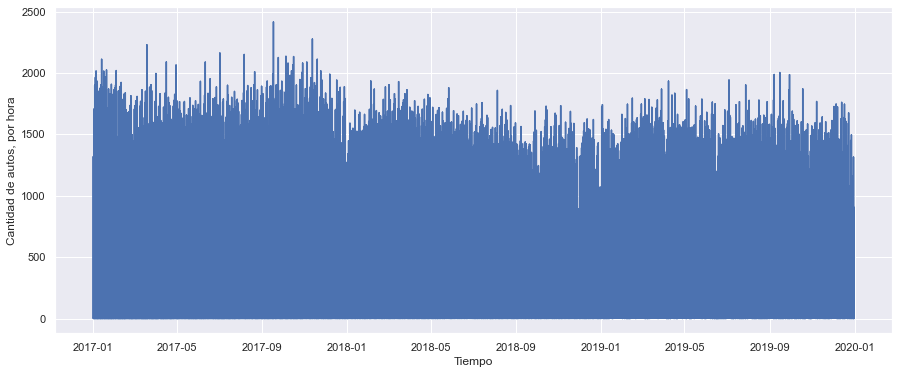

In [20]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset_illia.fecha, dataset_illia.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

#### Análisis con resampleos

In [21]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
illia_analisis = dataset_illia[['fecha','sentido', 'tipo_vehiculo', 'cantidad_pasos']]

In [22]:
diario = illia_analisis.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


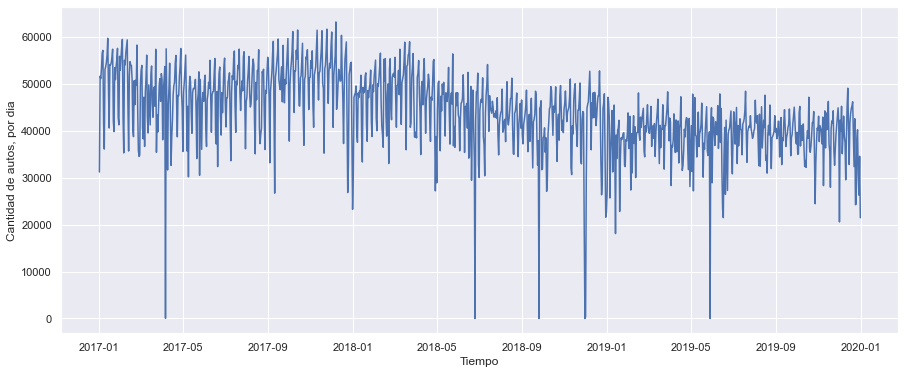

In [23]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [24]:
#Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
semanal = illia_analisis.resample('W', on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581


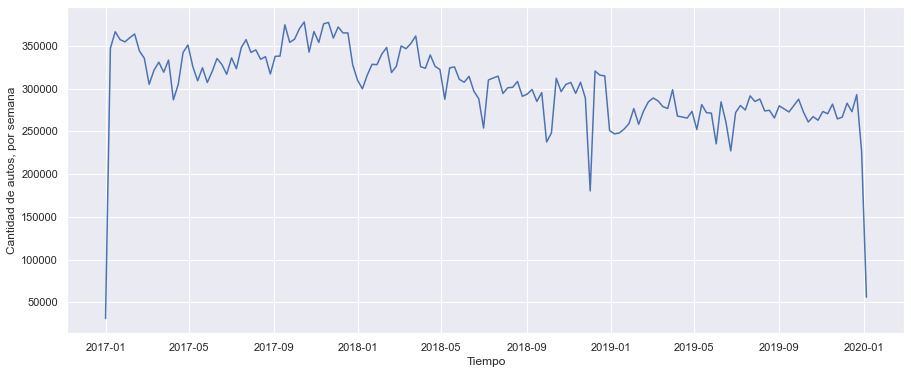

In [25]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

In [26]:
mensual = illia_analisis.resample('MS', on = 'fecha').sum()
print(mensual.shape)
mensual.head()

(36, 1)


,cantidad_pasos
fecha,
2017-01-01,1565260
2017-02-01,1363113
2017-03-01,1451214
2017-04-01,1373985
2017-05-01,1407136


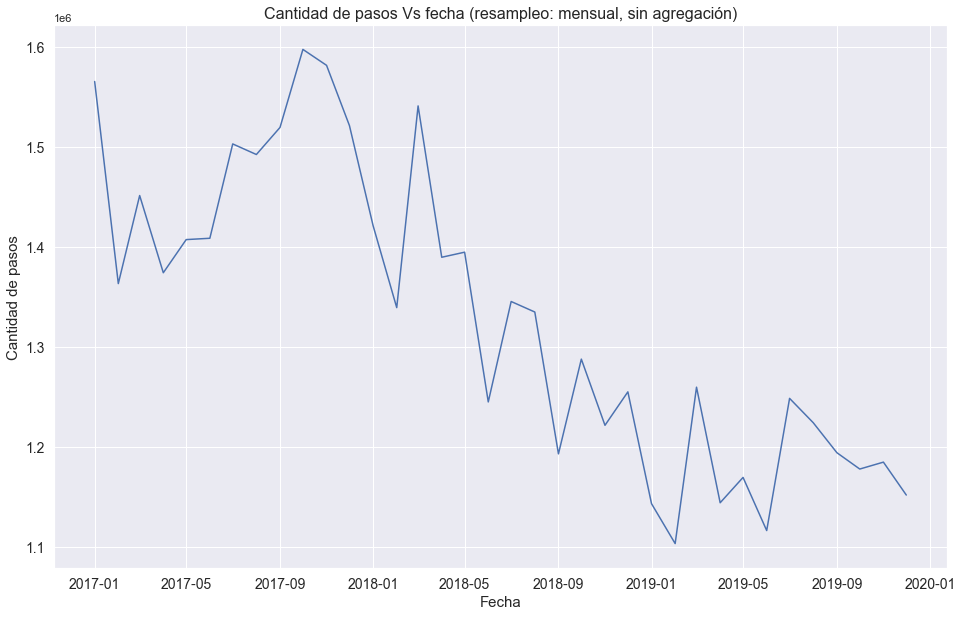

In [27]:
plt.figure(figsize=(16, 10))
sns.lineplot(data=mensual, x='fecha', y='cantidad_pasos')

#Formato de la gráfica
plt.title('Cantidad de pasos Vs fecha (resampleo: mensual, sin agregación)',fontsize=16)
plt.xlabel('Fecha', fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

* Este gráfico y el siguiente dejan en evidencia la tendencia hacia la baja de los vehículos que se registraron con pago en efectivo por la autopista Illia, 
las posibles razones serán explicadas en la parte de Investigación

##### Otra forma de visualizarlo

In [28]:
def lineplot(data: pd.DataFrame, x: str, y: str, **kwargs):
    """
    :param data:
    :param x:
    :param y:
    :param kwargs:
    :return:
    """
    return sns.relplot(x=x, y=y, data=data, kind='line', **kwargs)

In [29]:
dataset_analisis=dataset_illia.groupby([dataset_illia.mes,dataset_illia.periodo])['cantidad_pasos'].sum().to_frame().reset_index()
#dataset_analisis.periodo=dataset_analisis.periodo.astype('str')
#dataset_analisis.cantidad_pasos=round(100*(dataset_analisis.cantidad_pasos/dataset_analisis.cantidad_pasos.sum()),1)
dataset_analisis

,mes,periodo,cantidad_pasos
0,1,2017,1565260
1,1,2018,1421112
2,1,2019,1143023
3,2,2017,1363113
4,2,2018,1339086
5,2,2019,1103086
6,3,2017,1451214
7,3,2018,1540839
8,3,2019,1259526
9,4,2017,1373985


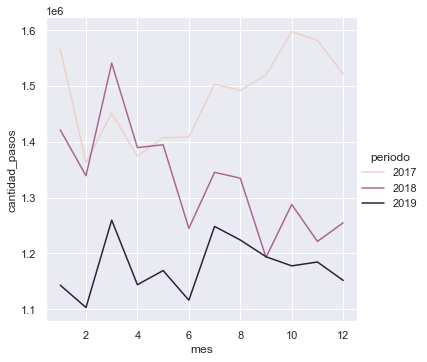

In [30]:
lineplot(x= 'mes', y= 'cantidad_pasos', data=dataset_analisis, hue= 'periodo')

##### Conclusión

* Este gráfico permite comparar los meses de cada periodo, por lo que se puede ver que los meses de febrero y junio suelen tener menos tránsito, para luego aumentar notablemente en el mes siguiente en ambos casos.
* También contribuye a la conclusión anterior, en cuanto a la disminución de vehículos que se registaron con pago en efectivo 

#### Analisis bivariado

##### - Breve, solo para observar de cerca 2 características

In [31]:
# Función que nos permite definir la relación de color con base en el minimo 
# y el maximo de un conjunto de datos y una paleta de color elegida
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

##### - Visualización por días de la semana de los 3 años juntos

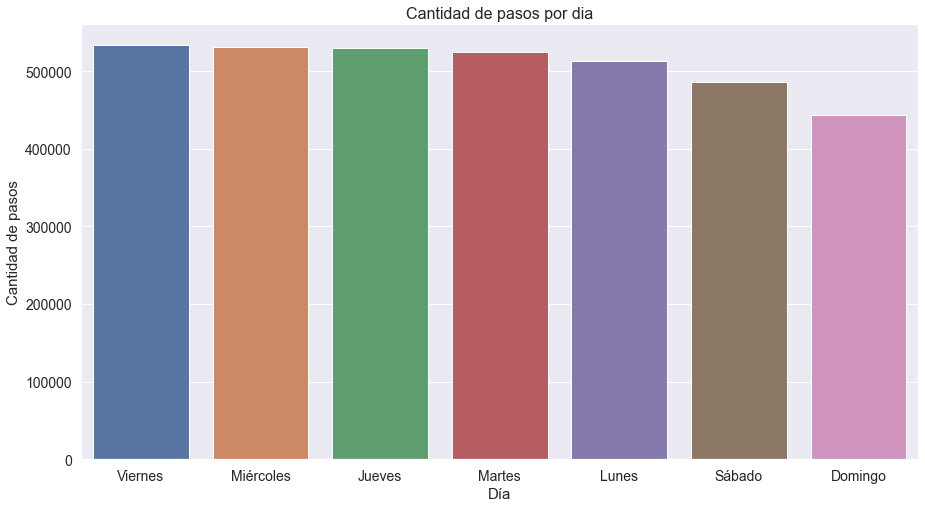

In [32]:
plt.figure(figsize=(15, 8))
sns.countplot(data=dataset,
              x = 'dia', 
              order = dataset['dia'].value_counts().index), 
palette=colors_from_values(dataset['cantidad_pasos'], 'tab20b')
    
plt.title('Cantidad de pasos por dia', fontsize=16)
plt.xlabel('Día', fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)
plt.tick_params(labelsize=14)

* Con esta visualización sabemos cuál es el día con mayor y menor cantidad de tránsito

#### Tipos de vehículos que la circulan

In [33]:
dataset_analisis=dataset.groupby([dataset.tipo_vehiculo])['cantidad_pasos'].sum().to_frame().reset_index()
#dataset_analisis.periodo=dataset_analisis.periodo.astype('str')
#dataset_analisis.cantidad_pasos=round(100*(dataset_analisis.cantidad_pasos/dataset_analisis.cantidad_pasos.sum()),1)
dataset_analisis

,tipo_vehiculo,cantidad_pasos
0,Liviano,338162233
1,Pesado,36472444


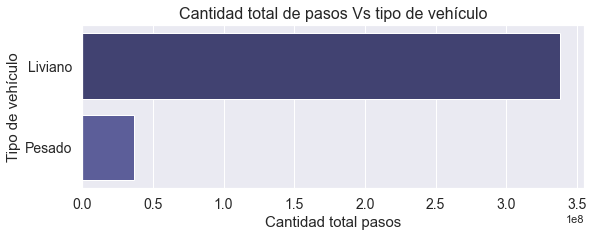

In [34]:
plt.figure(figsize=(9, 3))
sns.barplot(y="tipo_vehiculo", 
            x="cantidad_pasos", 
            data=dataset_analisis,
            palette= "tab20b")
#Formato de la gráfica
plt.title('Cantidad total de pasos Vs tipo de vehículo',fontsize=16)
plt.xlabel('Cantidad total pasos', fontsize=15)
plt.ylabel('Tipo de vehículo', fontsize=15)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

* Gracias a este barplot entendemos que la Autopista Illia es una autovía de vehículos livianos en su mayoría

#### Analisis multivariado

##### - La meta ahora es comparar cómo se comporta el flujo vehicular agregando otras variables

In [35]:
dataset_analisis=dataset.groupby([dataset.tipo_vehiculo,dataset.periodo])['cantidad_pasos'].sum().to_frame().reset_index()
dataset_analisis.periodo=dataset_analisis.periodo.astype('str')
dataset_analisis.cantidad_pasos=round(100*(dataset_analisis.cantidad_pasos/dataset_analisis.cantidad_pasos.sum()),1)
dataset_analisis

,tipo_vehiculo,periodo,cantidad_pasos
0,Liviano,2017,30.3
1,Liviano,2018,30.0
2,Liviano,2019,29.9
3,Pesado,2017,3.0
4,Pesado,2018,2.9
5,Pesado,2019,3.9


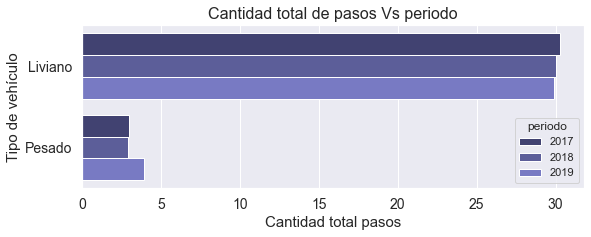

In [36]:
plt.figure(figsize=(9, 3))
sns.barplot(y="tipo_vehiculo", 
            x="cantidad_pasos", 
            hue="periodo", 
            palette= "tab20b",
            data=dataset_analisis,)
#Formato de la gráfica
plt.title('Cantidad total de pasos Vs periodo',fontsize=16)
plt.xlabel('Cantidad total pasos', fontsize=15)
plt.ylabel('Tipo de vehículo', fontsize=15)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

* Empezamos por ver el tránsito según los tipos de vehículos en cada año, en  decrecimiento en caso de los livianos y un leve aumento en el caso de los pesados para el período 2019 

In [37]:
dataset_analisis=dataset.groupby([dataset.dia_sem,dataset.periodo])['cantidad_pasos'].sum().to_frame().reset_index()
dataset_analisis.periodo=dataset_analisis.periodo.astype('str')
dataset_analisis.cantidad_pasos=round(100*(dataset_analisis.cantidad_pasos/dataset_analisis.cantidad_pasos.sum()),1)
dataset_analisis

,dia_sem,periodo,cantidad_pasos
0,0,2017,7.7
1,0,2018,7.4
2,0,2019,8.4
3,1,2017,25.7
4,1,2018,25.4
5,1,2019,25.4


<AxesSubplot:xlabel='dia_sem', ylabel='cantidad_pasos'>

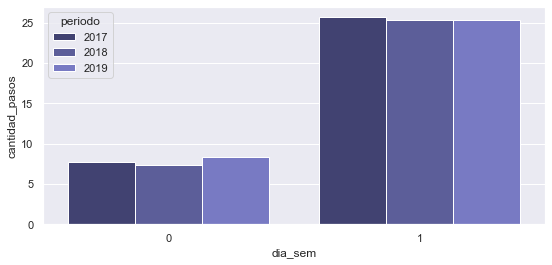

In [38]:
plt.figure(figsize=(9, 4))

sns.barplot(y="cantidad_pasos", 
            x="dia_sem", 
            hue="periodo", 
            palette= "tab20b",
            data=dataset_analisis,)

* El tránsito aquí agrupado en fines de semana(0) denota un ligero aumento en 2019 mientra se observa que de lunes a viernes (1) se mantuvo como en el año anterior

In [39]:
dataset_analisis=dataset.groupby([dataset.periodo,dataset.hora_fin])['cantidad_pasos'].sum().to_frame().reset_index()
dataset_analisis

,periodo,hora_fin,cantidad_pasos
0,2017,1,2012805
1,2017,2,1494631
2,2017,3,1035795
3,2017,4,806483
4,2017,5,974348
...,...,...,...
67,2019,20,6905351
68,2019,21,6056895
69,2019,22,4714698
70,2019,23,3373187


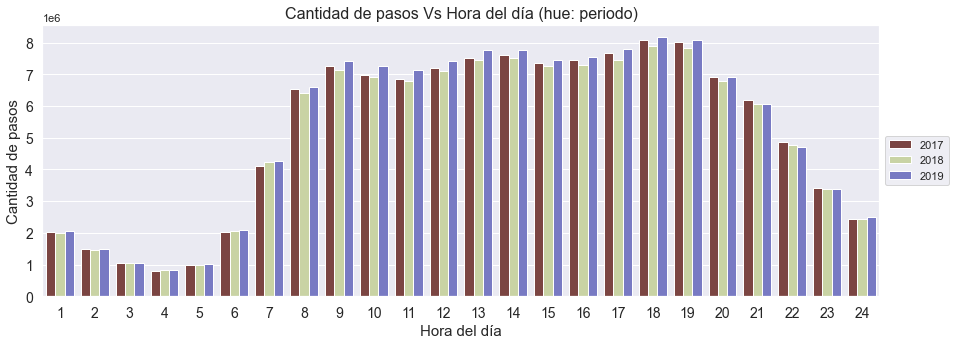

In [40]:
plt.figure(figsize=(15, 5))
sns.barplot(x="hora_fin", 
            y="cantidad_pasos", 
            hue='periodo',
            data=dataset_analisis,
            palette=colors_from_values(dataset_analisis['cantidad_pasos'], "tab20b")
            )
#Formato de la gráfica
plt.title('Cantidad de pasos Vs Hora del día (hue: periodo)',fontsize=16)
plt.xlabel('Hora del día', fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

*Cuando reparamos en las horas con mayor tránsito vehicular, vemos que en el horario entre las 16 y las 19 se encuentran lo que llamamos horas pico, y va disminuyendo mientras avanza la noche

In [41]:
dataset_analisis=dataset.groupby([dataset.sentido,dataset.hora_fin])['cantidad_pasos'].sum().to_frame().reset_index()
dataset_analisis

,sentido,hora_fin,cantidad_pasos
0,Centro,1,2538398
1,Centro,2,1906822
2,Centro,3,1355127
3,Centro,4,1090446
4,Centro,5,1505996
5,Centro,6,3669604
6,Centro,7,7918303
7,Centro,8,11801840
8,Centro,9,12434486
9,Centro,10,11761049


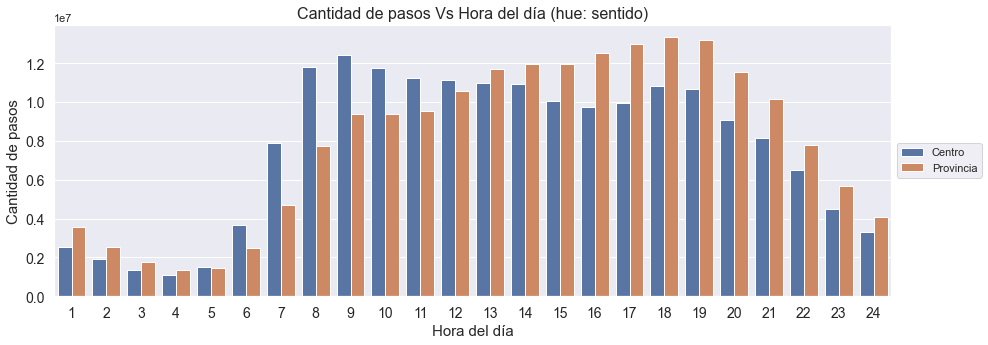

In [42]:
plt.figure(figsize=(15, 5))
sns.barplot(x="hora_fin", 
            y="cantidad_pasos", 
            hue='sentido',
            data=dataset_analisis,
            #palette=colors_from_values(dataset_analisis['cantidad_pasos'], "tab20b")
            )
plt.title('Cantidad de pasos Vs Hora del día (hue: sentido)',fontsize=16)
plt.xlabel('Hora del día', fontsize=15)
plt.ylabel('Cantidad de pasos', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

* Si seguimos observando las horas, pero esta vez tomando en cuenta el sentido en el que van los autos, notamos un aumento considerable del tránsito que se dirige en dirección al centro entre las 8 y las 10 de la mañana.
* Mientras que la cantidad de los que se dirigen a provincia aumenta especialmente entre las 17 y las 19, marcando así la vuelta o regreso, seguramente, de los que ingresaron durante el día a capital.  

## PARTE B: Modelo de Machine Learning
#### Pasos a seguir en la Parte B: 
#### - 1: Evaluar el comportamiento de la serie y sus componentes. 
#### - 2: Evaluar autocorrelación de la serie. 
#### - 3: Establecer un modelo Benchmark para poder comparar resultados. 
#### - 4: Predicción del último trimestre 2019 con Prophet. 

#### Métricas a utilizar: - RMSE: Raíz del error medio cuadrático.

In [43]:
### retomo el dataset armado al principio del notebook
dataset.head()

,fecha_comp,fecha,periodo,mes,hora_inicio,hora_fin,dia,dia_num,dia_sem,fin_sem,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Alberdi,Centro,Liviano,NO COBRADO,22
1,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Alberdi,Centro,Liviano,TELEPASE,6
2,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Alberdi,Provincia,Liviano,NO COBRADO,53
3,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Alberdi,Provincia,Liviano,TELEPASE,18
4,2019-01-01 01:00:00,2019-01-01,2019,1,0,1,Martes,1,1,0,Avellaneda,Centro,Liviano,EFECTIVO,16


In [44]:
diario.head()

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [45]:
#### 1 - Comportamiento de la serie y componentes
##### Con la función moving_average conocemos el promedio de la serie

In [46]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(diario, 4)

28227.5

In [47]:
def plotMovingAverage(series, window, plot_intervals=False, scale=3, 
                      plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

#### Y ahora, aunque son evidentes, destaco sus outliers

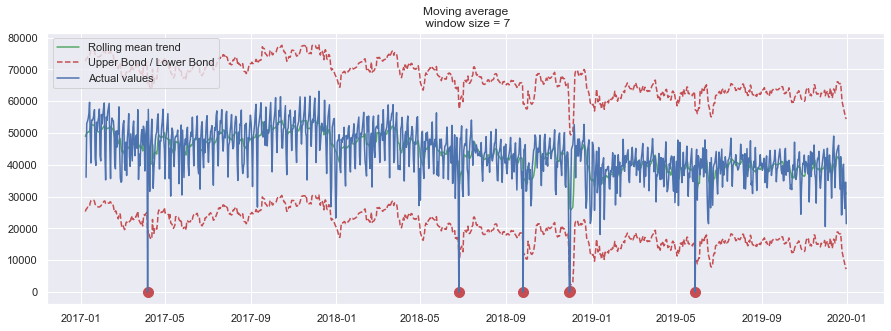

In [48]:
plotMovingAverage(diario, 7, plot_intervals=True, 
                  plot_anomalies=True)

#### Para eliminar los outliers, voy a especificar su fecha para luego imputarlos

In [49]:
outliers = diario[diario.cantidad_pasos < 1000]  
outliers

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


##### Al investigar un poco estas fechas notamos que :
##### - el 6 de abril de 2017 ocurrió un paro general en el país con manifestaciones en los accesos a capital. Fuente: https://www.lanacion.com.ar/politica/paro-del-6-de-abril-general-cgt-servicios-nid2005425/
##### - algo similar sucedió los días 25 de junio y 25 de septiembre del año 2018 y el 05 de mayo de 2019. Fuente:  https://www.infobae.com/opinion/2018/06/25/un-paro-extrano-en-medio-del-mundial/ , https://ei-ie-al.org/noticias/argentina-masiva-movilizacion-contra-politicas-de-ajuste , https://elpais.com/internacional/2019/05/29/argentina/1559153842_024679.html 
##### - En cambio, el 30 de noviembre y el 01 de diciembre el tránsito fue interrumpido por la realización de la cumbre del G-20, como lo indica la página de la ciudad : https://www.buenosaires.gob.ar/jefedegobierno/xiii-cumbre-lideres-g20/cumbre-del-g20-viernes-30-de-noviembre  

In [50]:
#genero un dataset con la información relativa a los outliers identificados
dia_outliers = pd.DataFrame(outliers)
dia_outliers.reset_index(inplace=True,drop=False)
dia_outliers

,fecha,cantidad_pasos
0,2017-04-06,40
1,2018-06-25,0
2,2018-09-25,0
3,2018-11-30,0
4,2018-12-01,350
5,2019-05-29,0


In [51]:
diario_ML = pd.DataFrame(diario)
diario_ML.reset_index(inplace=True,drop=False)
diario_ML

,fecha,cantidad_pasos
0,2017-01-01,31183
1,2017-01-02,51568
2,2017-01-03,51093
3,2017-01-04,53332
4,2017-01-05,56486
...,...,...
1090,2019-12-27,40182
1091,2019-12-28,30681
1092,2019-12-29,26259
1093,2019-12-30,34523


In [52]:
indices = diario_ML[diario_ML['cantidad_pasos']<1000].index.tolist()

In [53]:
indices

[95, 540, 632, 698, 699, 878]

In [54]:
diario_ML.loc[indices,'cantidad_pasos'] = 0

In [55]:
diario_ML['cantidad_pasos'].replace(to_replace=0, method='ffill',inplace =True)

##### Verificamos que no hayan quedado valores nulos en el dataset a usar : diario_ML

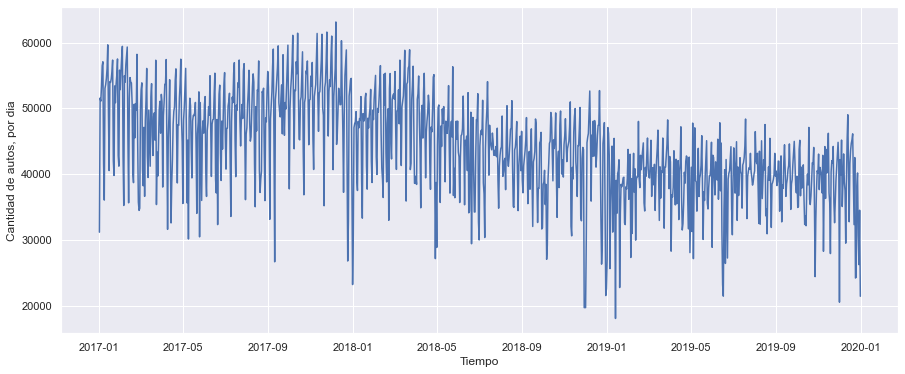

In [56]:
plt.figure(figsize = (15,6))
plt.plot(diario_ML.fecha, diario_ML.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

#### Ahora vemos los otros componentes de la serie

In [57]:
#agrego una columna con la fecha en formato numérico
diario_ML['fecha_numeros']=diario_ML.fecha.map(datetime.datetime.toordinal)
diario_ML.head()

,fecha,cantidad_pasos,fecha_numeros
0,2017-01-01,31183,736330
1,2017-01-02,51568,736331
2,2017-01-03,51093,736332
3,2017-01-04,53332,736333
4,2017-01-05,56486,736334


In [58]:
#seteo 'fecha' como índice del DataFrame
diario_ML = diario_ML.set_index('fecha')

In [59]:
diario_ML

,cantidad_pasos,fecha_numeros
fecha,,
2017-01-01,31183,736330
2017-01-02,51568,736331
2017-01-03,51093,736332
2017-01-04,53332,736333
2017-01-05,56486,736334
...,...,...
2019-12-27,40182,737420
2019-12-28,30681,737421
2019-12-29,26259,737422


In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(diario_ML.cantidad_pasos, model='additive')

In [61]:
result.trend

fecha
2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04    48904.285714
2017-01-05    49601.714286
                  ...     
2019-12-27    31197.428571
2019-12-28    30801.285714
2019-12-29             NaN
2019-12-30             NaN
2019-12-31             NaN
Name: trend, Length: 1095, dtype: float64

In [62]:
result.seasonal

fecha
2017-01-01   -6961.780429
2017-01-02   -1106.123286
2017-01-03     143.367958
2017-01-04    1979.981009
2017-01-05    3208.804269
                 ...     
2019-12-27    5219.387602
2019-12-28   -2483.637123
2019-12-29   -6961.780429
2019-12-30   -1106.123286
2019-12-31     143.367958
Name: seasonal, Length: 1095, dtype: float64

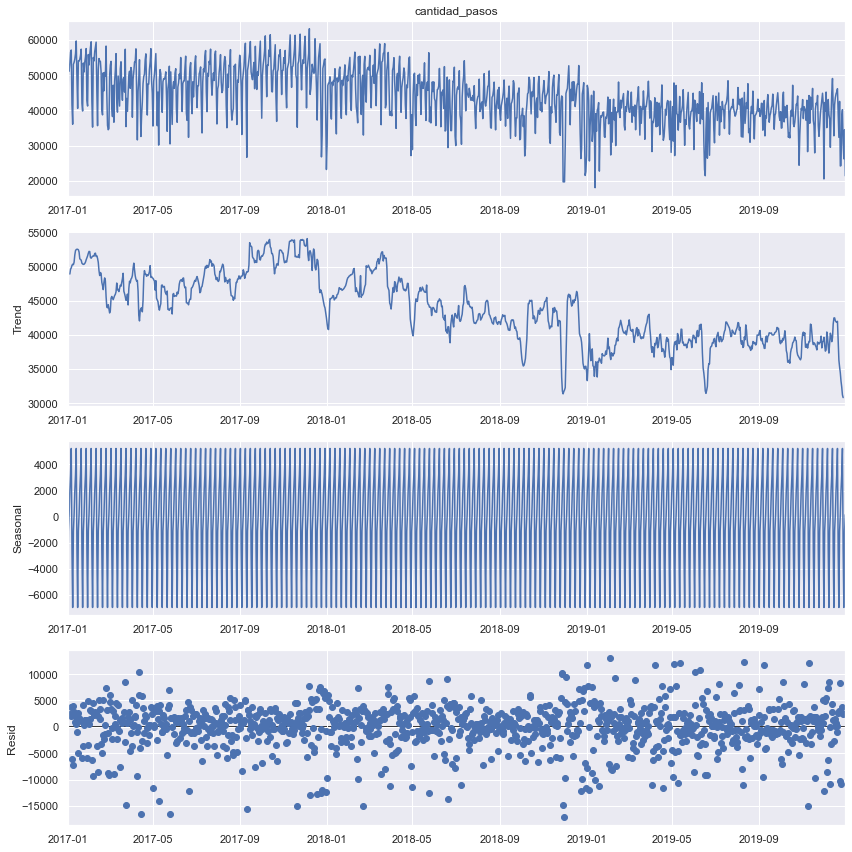

In [63]:
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

#### Observamos más de cerca la tendencia, graficándola de otra forma

<AxesSubplot:xlabel='fecha'>

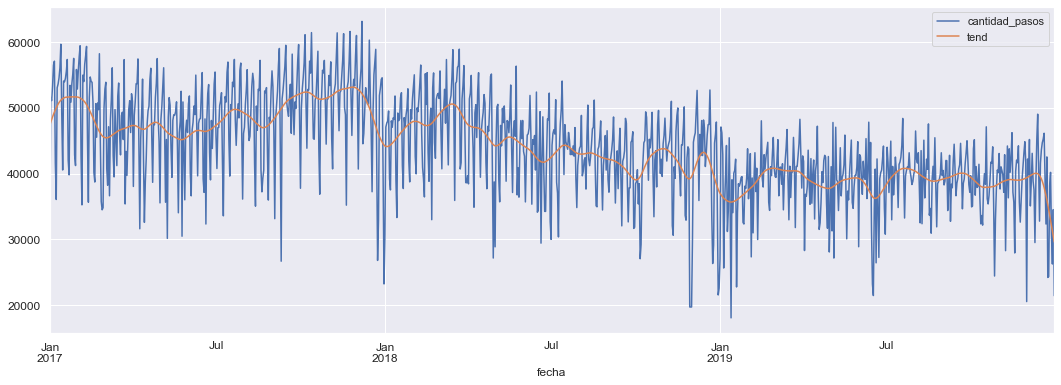

In [64]:
ciclo, tend = sm.tsa.filters.hpfilter(diario_ML['cantidad_pasos'])
diario_ML['tend'] = tend
diario_ML[['cantidad_pasos', 'tend']].plot(figsize=(18, 6), fontsize=12)

* Con estos gráficos podemos ver que hay cierta estacionalidad anual, en especial los primeros 2 años de análisis, siempre con tendencia a hacia la baja, aplanándose el último año

#### 2 - Verificamos Autocorrelación de la serie

In [65]:
from statsmodels.tsa.stattools import acf
nlags =  52
autocorr = acf(diario_ML.cantidad_pasos, nlags = nlags , fft = True)

In [66]:
autocorr.shape

(53,)

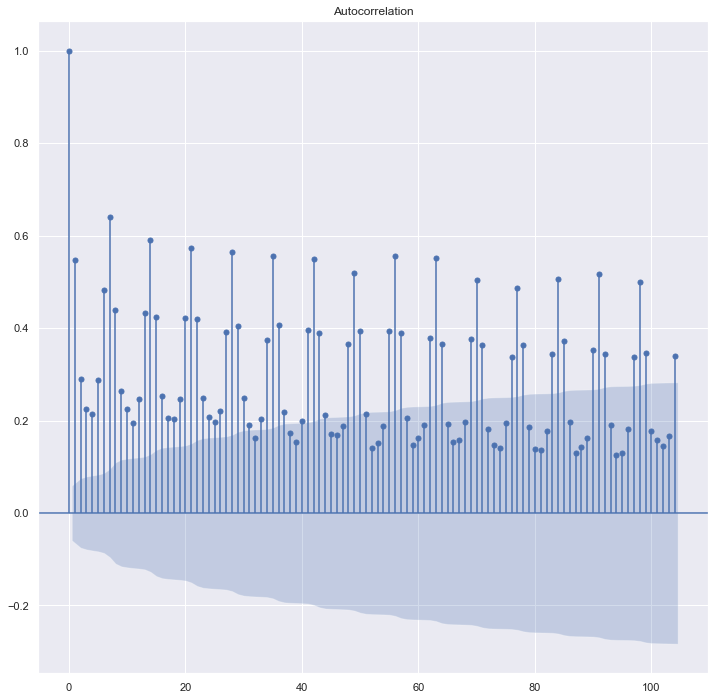

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diario_ML.cantidad_pasos, lags = 52*2)
plt.show()

* Existe un patrón que se repite cada 7 días, lo cual tiene sentido ya que la cantidad de automóviles que circulan depende del día del que se tenga en consideración.

#### 3 - Modelo Benchmark - Regresión Lineal

In [69]:
split_date = '2019-09-30'

train = diario_ML.loc[diario_ML.index <= split_date].copy()
test  = diario_ML.loc[diario_ML.index >  split_date].copy()

In [70]:
from sklearn.linear_model import LinearRegression
benchmark_rl = LinearRegression()
benchmark_rl.fit(train.fecha_numeros.values.reshape(-1, 1), train.cantidad_pasos)

LinearRegression()

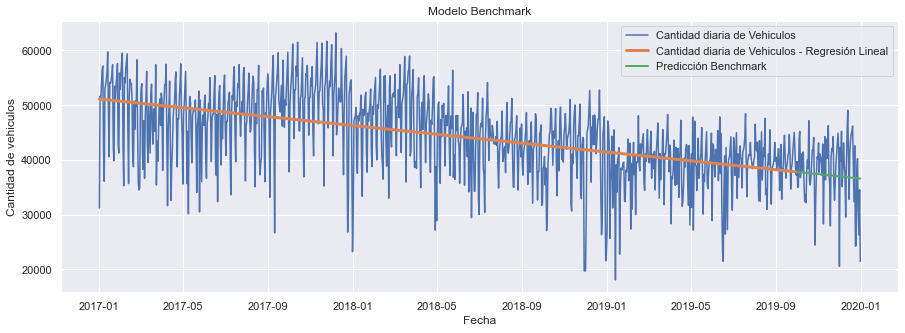

In [71]:
plt.figure(figsize = (15,5))
plt.plot(diario_ML.index, diario_ML.cantidad_pasos, label = 'Cantidad diaria de Vehiculos')
plt.plot(train.index, benchmark_rl.predict(train.fecha_numeros.values.reshape(-1, 1)), lw = 3, label = 'Cantidad diaria de Vehiculos - Regresión Lineal')
plt.plot(test.index,  benchmark_rl.predict(test.fecha_numeros.values.reshape(-1, 1)),  lw = 2, label = 'Predicción Benchmark')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehiculos')
plt.legend()
plt.title("Modelo Benchmark")
plt.show()

##### - RMSE del modelo Benchmark

In [72]:
from sklearn.metrics import mean_squared_error
benchmark_rmse = np.sqrt(mean_squared_error(test.cantidad_pasos, benchmark_rl.predict(test.fecha_numeros.values.reshape(-1, 1))))

print('RMSE modelo Benchmark: %.1f' % benchmark_rmse)

RMSE modelo Benchmark: 5831.2


#### 4 - Predicción con Prophet

In [73]:
from fbprophet import Prophet

In [74]:
diario_ML.reset_index(inplace=True,drop=False)
diario_ML

,fecha,cantidad_pasos,fecha_numeros,tend
0,2017-01-01,31183,736330,47372.160715
1,2017-01-02,51568,736331,47802.709687
2,2017-01-03,51093,736332,48223.140433
3,2017-01-04,53332,736333,48625.688035
4,2017-01-05,56486,736334,49004.381235
...,...,...,...,...
1090,2019-12-27,40182,737420,32942.342939
1091,2019-12-28,30681,737421,32126.428865
1092,2019-12-29,26259,737422,31297.123801
1093,2019-12-30,34523,737423,30460.144199


In [75]:
diario_ML = diario_ML.drop(columns=['fecha_numeros', 'tend'])
diario_ML['ds'] = pd.to_datetime(diario_ML['fecha'])
diario_ML = diario_ML.drop(columns=['fecha'])
diario_ML = diario_ML.rename(columns = {'cantidad_pasos':'y'})
diario_ML

,y,ds
0,31183,2017-01-01
1,51568,2017-01-02
2,51093,2017-01-03
3,53332,2017-01-04
4,56486,2017-01-05
...,...,...
1090,40182,2019-12-27
1091,30681,2019-12-28
1092,26259,2019-12-29
1093,34523,2019-12-30


In [76]:
diario_ML = diario_ML[['ds' , 'y']]
diario_ML

,ds,y
0,2017-01-01,31183
1,2017-01-02,51568
2,2017-01-03,51093
3,2017-01-04,53332
4,2017-01-05,56486
...,...,...
1090,2019-12-27,40182
1091,2019-12-28,30681
1092,2019-12-29,26259
1093,2019-12-30,34523


##### - Train/test split utilizando como corte el último trimestre de 2019

In [77]:
train_ph = diario_ML.loc[diario_ML.ds < split_date].copy()
test_ph = diario_ML.loc[diario_ML.ds >= split_date].copy()

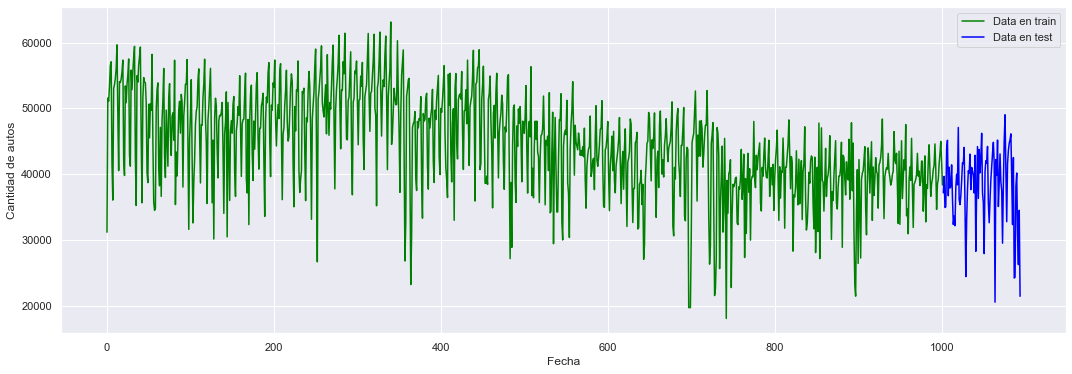

In [78]:
plt.figure(figsize=(18,6))
plt.plot(train_ph['y'],label='Data en train',color='green')
plt.plot(test_ph['y'],label='Data en test',color='blue')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos')
plt.show()

##### -  Predicción con Prophet

In [79]:
prop = Prophet(weekly_seasonality=True)
prop.fit(train_ph)
predic = prop.make_future_dataframe(periods=92, freq='D')
forecast = prop.predict(predic)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1089,2019-12-26,42187.631300,36859.320949,48246.297350
1090,2019-12-27,43894.790666,38039.967732,50312.602350
1091,2019-12-28,35576.840650,29479.333294,41634.175028
1092,2019-12-29,30754.684178,24689.146341,36722.544794
1093,2019-12-30,36674.956035,30625.143058,42639.127650


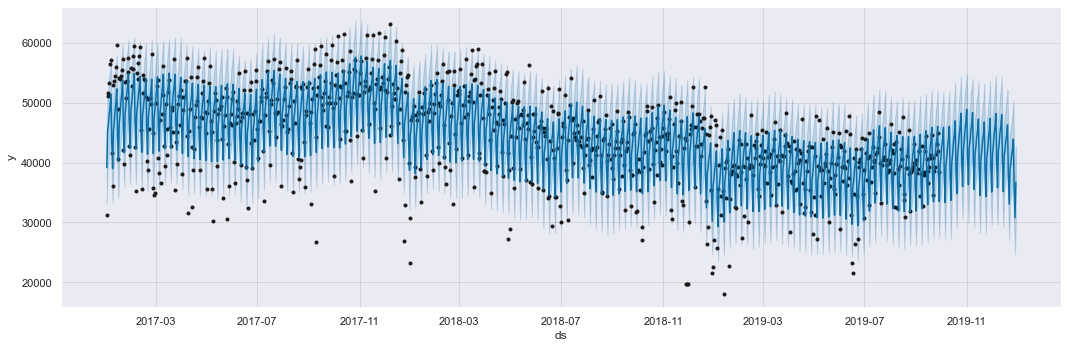

In [80]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prop.plot(forecast,
                 ax=ax)
plt.show()

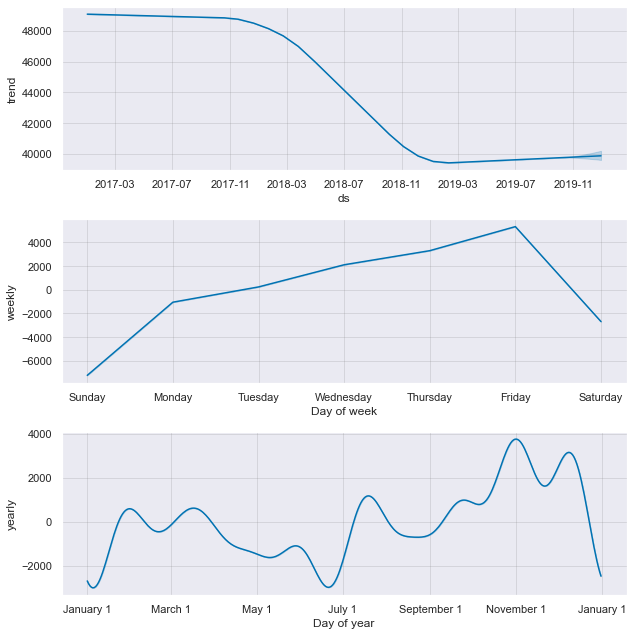

In [81]:
fig2 = prop.plot_components(forecast)

##### - RMSE del modelo Prophet

In [82]:
from sklearn.metrics import mean_squared_error
rmseprop = (mean_squared_error(test_ph['y'], forecast.yhat[-93:]))
print(f'RMSE: {round(np.sqrt(rmseprop),3)}')

RMSE: 6770.226


* Si comparamos con el modelo Benchmarck(5831.2) vemos que el error en este caso es mayor, por lo que procedo con cross-validation para probar si se puede mejorar

In [83]:
from fbprophet.diagnostics import cross_validation

In [84]:
cvprop= cross_validation(prop, initial='366 days',horizon='92 days')

INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-08 00:00:00 and 2019-06-29 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

In [85]:
from fbprophet.diagnostics import performance_metrics
metric = performance_metrics(cvprop)
metric

,horizon,mse,rmse,mae,mape,mdape,coverage
0,10 days,3.419234e+07,5847.421366,4615.601016,0.121416,0.086120,0.704545
1,11 days,3.471953e+07,5892.328121,4682.032810,0.123293,0.089562,0.680303
2,12 days,3.435793e+07,5861.564134,4599.554518,0.120405,0.089562,0.684848
3,13 days,3.488243e+07,5906.135008,4652.695603,0.122209,0.091092,0.683333
4,14 days,3.368331e+07,5803.732200,4527.651453,0.116335,0.088992,0.701515
...,...,...,...,...,...,...,...
78,88 days,6.243788e+07,7901.764118,6441.166895,0.165891,0.152697,0.431818
79,89 days,6.440291e+07,8025.142353,6540.603501,0.167709,0.153932,0.440909
80,90 days,6.841525e+07,8271.350909,6661.216561,0.170919,0.152607,0.427273
81,91 days,6.776871e+07,8232.175576,6663.919888,0.170777,0.150313,0.431818


In [86]:
print(f'RMSE para un horizonte de 92 días: {round(metric.iloc[82,2],3)}')

RMSE para un horizonte de 92 días: 8190.931


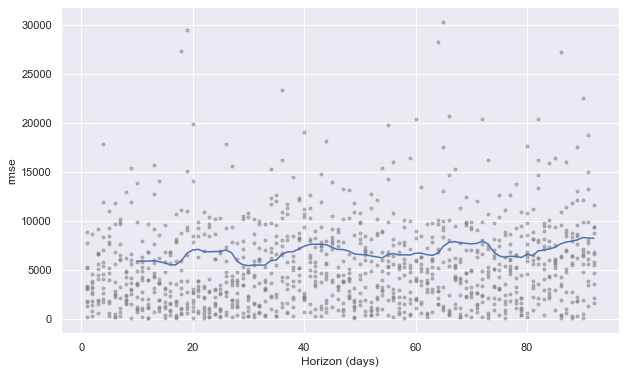

In [87]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cvprop, metric='rmse')

##### - Para tener una mejor idea de cúanto representa el error, voy a usar una métrica con porcentaje RMSPE

In [88]:
rmspe = (np.sqrt(np.mean(np.square((test_ph['y'] - forecast.yhat[-93:]) / test_ph['y'])))) * 100
print(f'Porcentaje de error: {(rmspe)}')

Porcentaje de error: 20.072732988868424


#### Conclusión a partir del modelo utilizado

* El gráfico del RMSE muestra que a partir de los 40 días de horizonte, el rmse va en aumento. Por lo tanto el aplicar Cross Validation (teniendo en cuenta el horizonte temporal de 92 días, haciendo referencia al último trimestre del 2019) no mejora su performance. Aún así, como se ve en el gráfico de componentes, respeta la estacionalidad semanal de la serie y a nivel anual, que el tránsito tiende a aumentar en octubre y noviembre, para decaer notablemente a finales de diciembre.

### PARTE C: Investigación

- En lo que respecta a la disminución de vehículos que se registraron con pago en efectivo, visible en el desarrollo de este notebook, una de las principales causas parece ser la implementación de un nuevo sistema de peaje inteligente a partir de marzo del 2019:
"mejora la fluidez de la circulación de vehículos, aumenta la seguridad vial en la traza, reduce las congestiones, aporta mayor comodidad para el usuario y disminuye el impacto medioambiental generado por la utilización de autopistas." Fuente: https://revistavial.com/autopistas-sin-barreras-la-nueva-tecnologia-de-la-ciudad/
- Otro hecho que pudo haber afectado es la construcción de una nueva traza. Fuentes: https://www.ausa.com.ar/novedades/urbanizacion-barrio-31-construiremos-una-nueva-via-rapida-urbana-illia/ y https://www.buenosaires.gob.ar/compromisos/paseo-del-bajo-conectar-illia-au-la-plata

####  Mejoras para proyecto 4

##### - Probar este dataset con XGBoost, ya que ese algoritmo permite analizar multiples variables a la vez, lo cual espero pueda no solo mejorar el  resultado, si no también demostrar cómo influyen al mismo, obteniendo así una visión más general.

##### Link al repositorio en Github

##### https://github.com/rgtelma/Series-de-tiempo-Proyecto3